
... ***CURRENTLY UNDER DEVELOPMENT*** ...


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from scipy.stats import linregress

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.rbf import RBF_Interpolation
from teslakit.mda import Normalize
from teslakit.statistical import runmean
from teslakit.tides import Calculate_MMSL


from teslakit.plotting.tides import Plot_Tide_SLR, Plot_Tide_RUNM, Plot_Tide_MMSL



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


# --------------------------------------
# parameters for mmsl calculation
mmsl_year_ini = 1996
mmsl_year_end = 2017



### VARIABLES

##### Historical levels:

<xarray.Dataset>
Dimensions:    (time: 184104)
Coordinates:
  * time       (time) datetime64[ns] 1996-01-01 ... 2016-12-31T23:00:00.000002944
Data variables:
    observed   (time) float64 ...
    predicted  (time) float64 ...


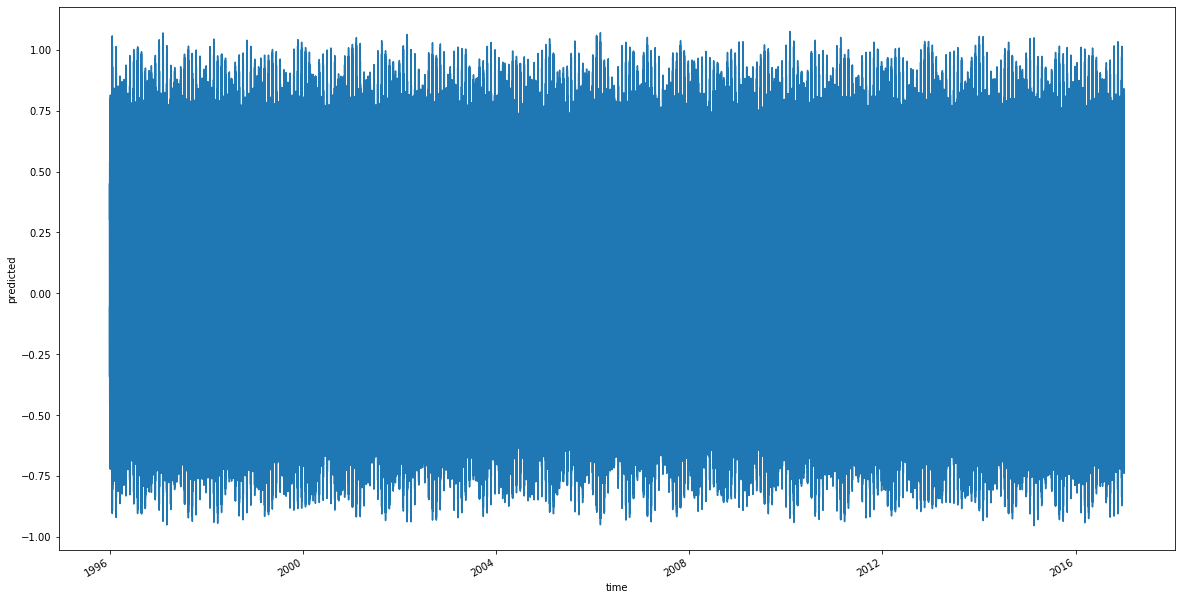

In [3]:
# --------------------------------------
# Astronomical Tide (AT)

_, TIDE = db.Load_TIDE_hist()  
TIDE = TIDE.drop_vars('ntr')
TIDE = TIDE.drop_vars('sigma')
print(TIDE)

AT = (TIDE.predicted - np.nanmean(TIDE.predicted.values[:])) 

plt.figure(figsize=(20,10))
AT.plot()

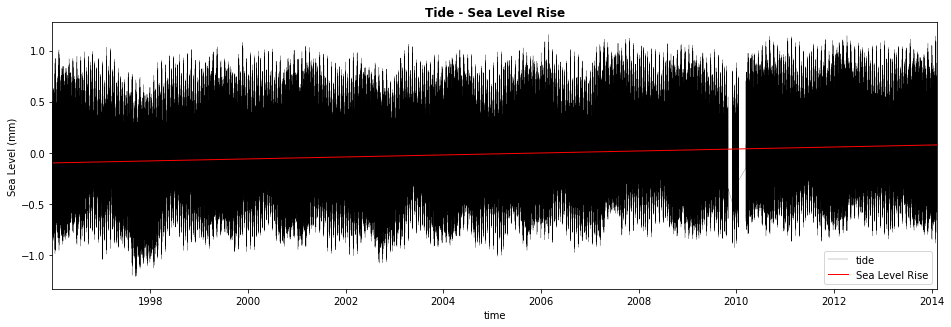

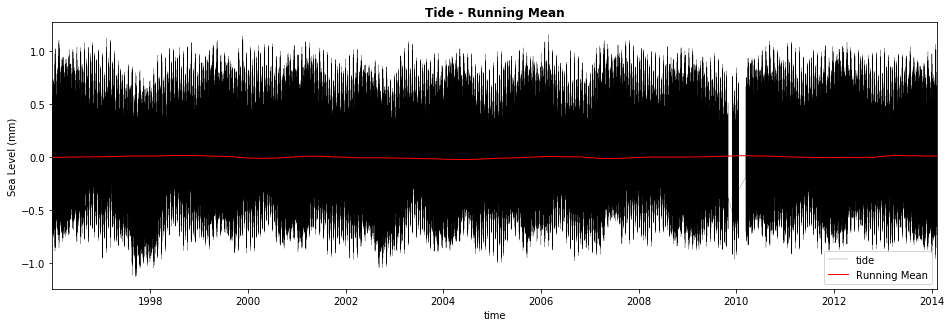

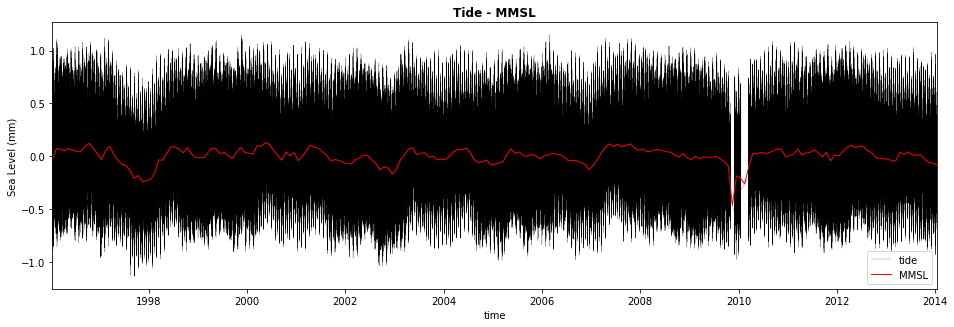

In [4]:
# --------------------------------------
# Monthly Mean Sea Level (MMSL)

SL = (TIDE.observed - np.nanmean(TIDE.observed.values[:]))
SL = SL.dropna(dim='time')
SL = SL.resample(time='1H').interpolate("linear")

# obtain SLR
lr_time = np.array(range(len(SL.time)))  # for linregress
ind_nan = np.where(~np.isnan(SL.values)) # ind no NaNs
slope, intercept, r_value, p_value, std_err = linregress(lr_time[ind_nan], SL.values[ind_nan])
slr = intercept + slope * lr_time

# Plot tide with SLR
Plot_Tide_SLR(SL.time, SL, slr);

# remove SLR 
SL_noslr = SL - slr

# calculate running mean
time_window = 365*24*3
runm = runmean(SL_noslr, time_window, 'mean')

# Plot SL without SLR and runm
Plot_Tide_RUNM(SL_noslr.time, SL_noslr, runm);

# remove running mean
SL_noslr_norunm = SL_noslr - runm

# store data 
SLNSR = xr.DataArray(SL_noslr_norunm,  dims=('time'), coords={'time':SL.time.values})

# calculate MMSL
MMSL = Calculate_MMSL(SLNSR, mmsl_year_ini, mmsl_year_end)
mmsl_time = MMSL.time.values[:]
mmsl_vals = MMSL.mmsl.values[:]

# Plot tide and mmsl 
Plot_Tide_MMSL(SLNSR.time, SLNSR.values, mmsl_time, mmsl_vals);


# from monthly to hourly
MMSL = MMSL.mmsl.resample(time='1H').interpolate("linear")


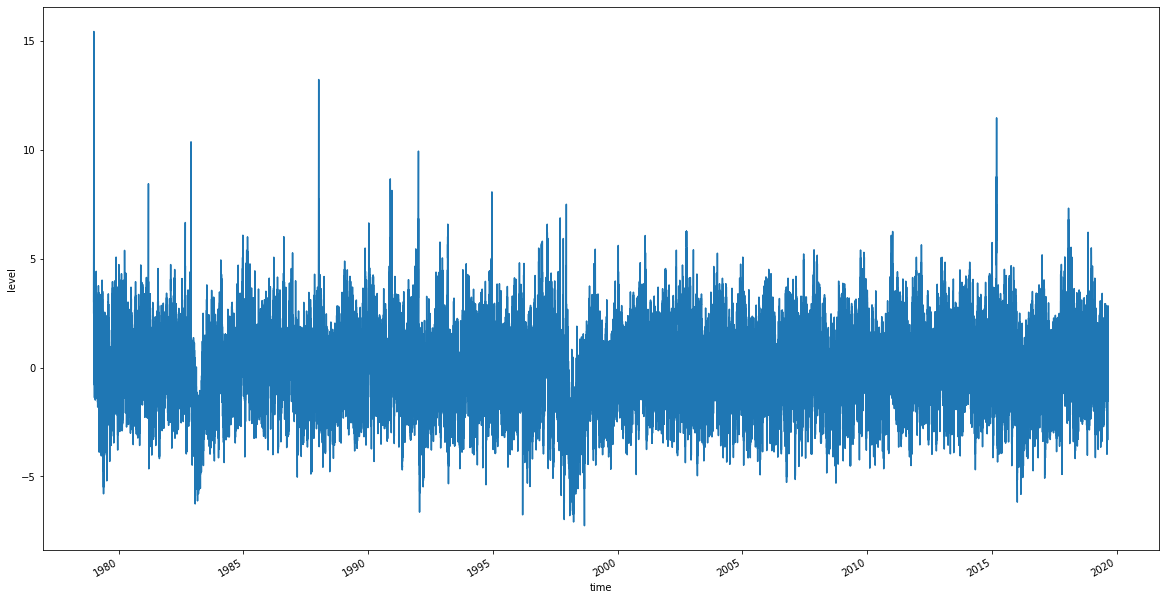

In [5]:
# --------------------------------------
# Inverse Barometer (IB)

SLP = db.Load_ESTELA_SLP()                # Sea Level Pressure from CFSR (Pa)
SLP_p = SLP.sel(longitude = 168, latitude = 8) # pnt_lon = 167.73, pnt_lat = 8.66


IB = xr.Dataset({'SLP': (('time',), ((SLP_p.SLP - np.mean(SLP_p.SLP.values)) * 0.01))}, # (mb)
                         coords = {'time': SLP_p.time.values})

IB['level'] = (('time'), -1*IB.SLP) # (cm)

plt.figure(figsize=(20,10))
IB.level.plot()


<xarray.DataArray 'predicted' (time: 157776)>
array([ 0.40100827,  0.56500827,  0.61900827, ..., -0.50999173,
       -0.64299173, -0.61399173])
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00

<xarray.DataArray 'mmsl' (time: 157776)>
array([-0.02968394, -0.02954135, -0.02939876, ..., -0.0871816 ,
       -0.08721253, -0.08724345])
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00

<xarray.Dataset>
Dimensions:  (time: 157776)
Coordinates:
  * time     (time) datetime64[ns] 1996-01-17 ... 2014-01-15T23:00:00
Data variables:
    SLP      (time) float64 0.7054 -0.3889 -0.8767 ... -0.8633 -0.5786 -0.6715
    level    (time) float64 -0.7054 0.3889 0.8767 1.007 ... 0.8633 0.5786 0.6715


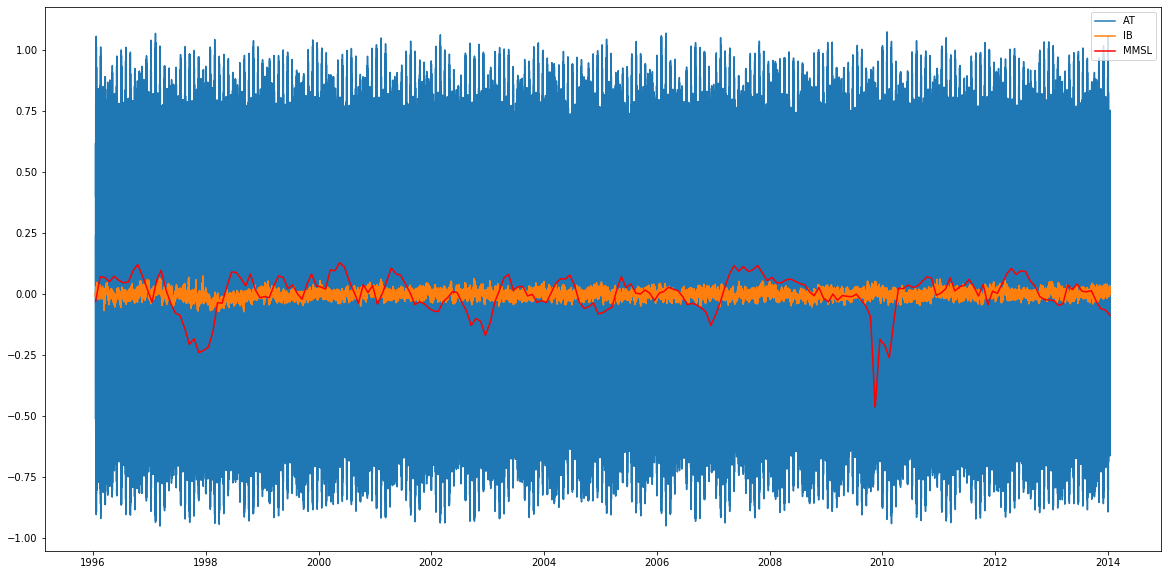

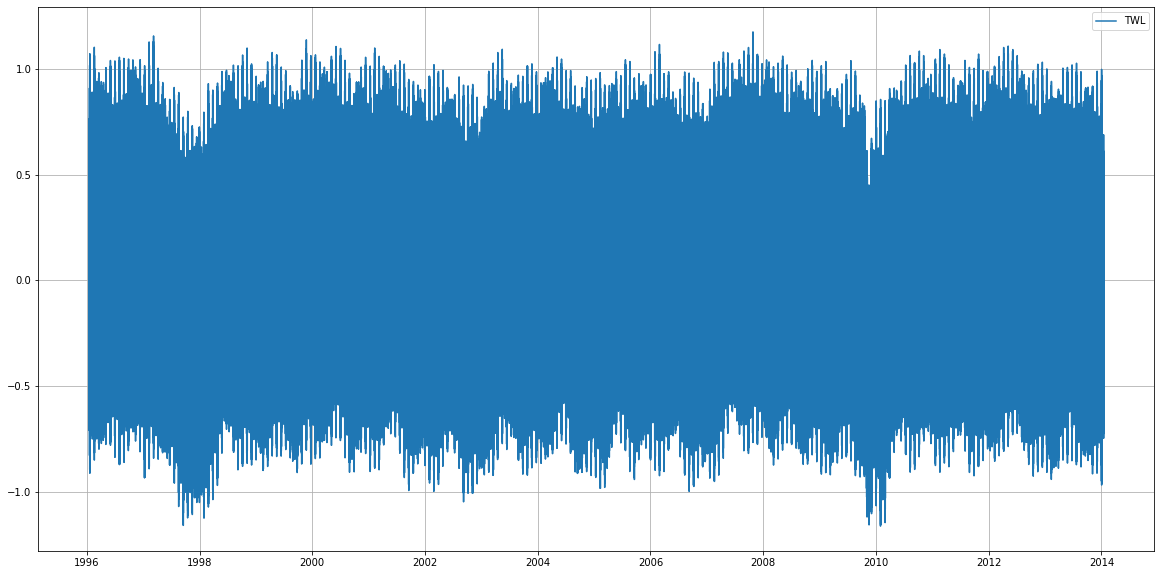

In [27]:
# --------------------------------------
# Compute Level

# hourly values
AT['time'] = AT['time'].dt.round('H')
MMSL['time'] = MMSL['time'].dt.round('H')
IB['time'] = IB['time'].dt.round('H')

# remove duplicates
_, ix = np.unique(AT['time'], return_index=True); AT = AT.isel(time=ix)
_, ix = np.unique(MMSL['time'], return_index=True); MMSL = MMSL.isel(time=ix)
_, ix = np.unique(IB['time'], return_index=True); IB = IB.isel(time=ix)


# get common dates
AT = AT.sel(time = slice('1996-01-17', '2014-01-15'))
MMSL = MMSL.sel(time = slice('1996-01-17', '2014-01-15'))
IB = IB.sel(time = slice('1996-01-17', '2014-01-15'))

print(AT)
print()
print(MMSL)
print()
print(IB)

# Obtain TWL
level = AT + MMSL + IB.level/100.0 # meters

plt.figure(figsize=(20,10))
plt.plot(AT.time, AT, label='AT')
plt.plot(IB.time, IB.level/100.0, label='IB')
plt.plot(MMSL.time, MMSL, color = 'r', label='MMSL')
plt.legend()

plt.figure(figsize=(20,10))
plt.plot(level.time, level, label = 'TWL')
plt.legend()
plt.grid()

##### TWL histogram

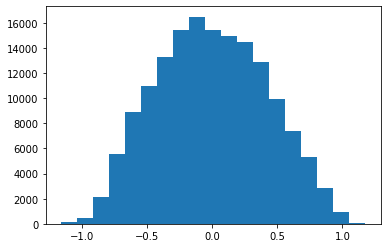

[  0.   5.  10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.
  70.  75.  80.  85.  90.  95. 100.]

[-1.16204652 -0.67516419 -0.5638332  -0.47117498 -0.38855261 -0.31694876
 -0.25128657 -0.19003143 -0.13102684 -0.07209204 -0.01113635  0.05217978
  0.11604283  0.18222748  0.24708157  0.31515189  0.38790425  0.47103565
  0.57345476  0.71092341  1.17572572]


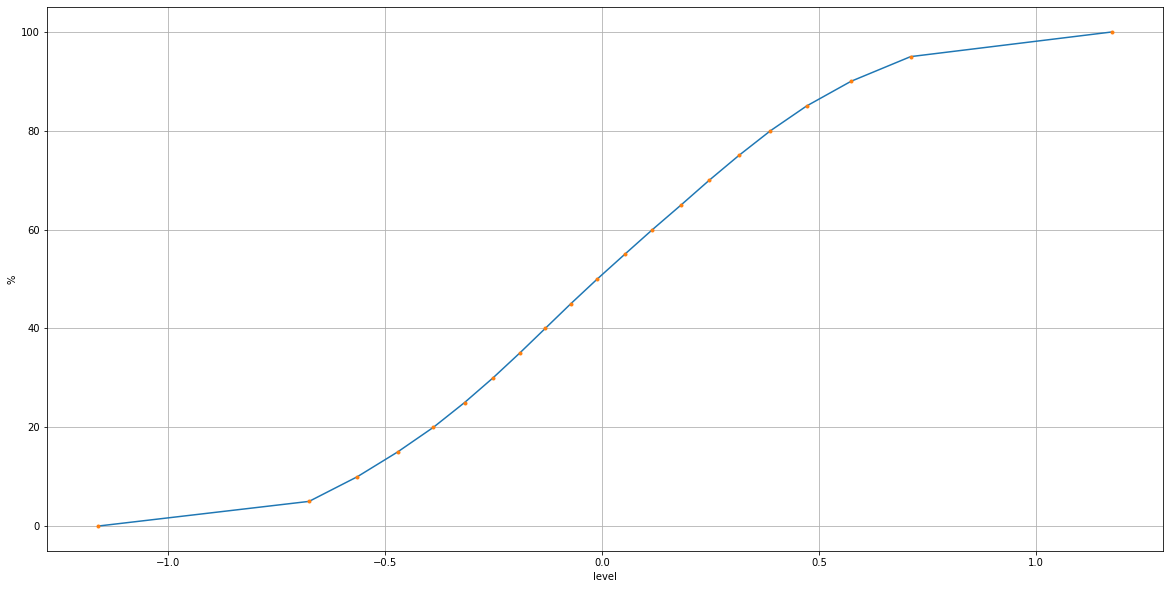

In [43]:
# histogram
bins_number = 20 
bins = np.linspace(np.min(level.values), np.max(level.values), bins_number)

n, _, _ = plt.hist(level.values, bins)
plt.show()


# percentiles
q = np.linspace(0,100,21)
perc = np.percentile(level.values, q)

plt.figure(figsize=(20,10))
plt.plot(perc, q)
plt.plot(perc, q, '.')
plt.xlabel('level')
plt.ylabel('%')
plt.grid()

print(q)
print()
print(perc)


In [44]:
level.to_netcdf('TWL.nc')